# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy, copy


### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- We will check the correctness of your implementation using the tests below.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [24]:
from scipy.stats import norm, bernoulli, multinomial
import warnings

ALPHA = 1.0 # for additive smoothing

# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        mean, std = norm.fit(X)
        
        # std should never be 0 to prevent division by zero errors
        if std == 0:
          std = 10 ** -6
        
        self.theta = {"mean": mean, "std": std}
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        return norm.logpdf(X_new, self.theta["mean"], self.theta["std"])
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

        
        
def laplace_smoothing(X, dim, value, a=ALPHA):
    # count how often value appears in X ("pseudocount")
    amount_of_value_in_X = (X == value).sum()
    # return the smoothened probability
    return (amount_of_value_in_X + a) / (len(X) + a*dim)


# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################

        dim = 2 # 2 dimensions because we are dealing with binary features
        p = laplace_smoothing(X, dim, 1) # the probability of x=1
        # NOTE: the probability of x=0 would be 1 - p
        
        self.theta = {'p': p}

        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        return bernoulli.logpmf(X_new, self.theta['p'], loc=0)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories
    
    # to access the variable “num_of_categories“
    # TODO: is this really needed? refactor as setter?
    def access_categories(self, num_of_categories):
        self._num_of_categories = num_of_categories
        
        
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        
        probabilities = []
        for category in range(0, self._num_of_categories):
            dim = self._num_of_categories
            p = laplace_smoothing(X, dim, category)
            probabilities.append(p)
            
        # show warning if the probabilities do not sum up to 1
        if np.sum(probabilities) != 1:
            warnings.warn('The probabilites do not sum up to 1!')
        
        self.theta = {'p': probabilities}
        
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
        
    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        
        log_probs = []
        num_of_trials = 1 # multinoulli is a special case multinomial distribution with just 1 trial
        
        for category in X_new:
          x = [0] * self._num_of_categories
          x[category] = 1
          prob = multinomial.logpmf(x, num_of_trials, self.theta['p'])
          log_probs.append(prob)
            
        return np.array(log_probs)
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

**Tests:**
    
We will use the code below to test the correctness of your code.

In [3]:
# continuous features

X = np.array([2.70508547, 2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
param2 = ContFeatureParam()
probs = param.get_log_probability(np.array([0,1,3,4,5]))
print(probs)


[-5.64670664 -3.02757918 -0.90099277 -1.39353383 -2.92329773]


In [6]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [25]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.94591015 -2.1690537  -1.94591015 -2.45673577 -2.1690537  -2.86220088
 -1.94591015 -3.55534806 -2.1690537  -2.86220088]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [6]:
# Your task is to implement the three functions of NBC. 

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[]):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################      
        # Helper Function to evaluate the correct distribution for the features within the "feature_type"-Array
        feat_paras = []
        for feat_type in feature_types:
            if feat_type == "r":
                feat_p = ContFeatureParam()
            elif feat_type == "b":
                feat_p = BinFeatureParam()
            elif feat_type == "c":
                # We choose zero as a dummy. Mainly to be able to call the function at this point
                feat_p = CatFeatureParam(0)
            feat_paras.append(feat_p)
        
        self._feat_paras = feat_paras
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################

        
    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        
        # set num of categorial feature params
        for idx, feat_para in enumerate(self._feat_paras):
           if isinstance(feat_para, CatFeatureParam):
            feat_col = X[:,idx] # 50x1 Column
            max_feat_col = np.max(feat_col)
            feat_para.access_categories(max_feat_col+1)

        #1) initialize the theta matrix and prior array
        
        # get dimensions of theta matrix
        self._classes = np.unique(y) 
        n_classes = len(self._classes)
        n_features = len(self._feat_paras)
        
        # initialize prior array and theta matrix according to the above calculated dimensions
        self._pi = np.zeros(n_classes) # [0,0,0]
        self._theta = np.full((n_classes, n_features), None) # 3 Classes x 4 Features Matrix 
                
        #2) Define a function to calculate the prior and thete
        def _calculate_theta_prior(X,y):
            # estimate a parameter theta for each class c and each feature
            for i, c in enumerate(self._classes):
                self._pi[i]= (y==c).sum() / len(y)
                for j, feature_param in enumerate(self._feat_paras): # [Cont, Cont, Bin, Cat]
                    # only samples where y == c
                    X_temp = X[y == c, j]   
                    feature_param.estimate(X_temp)
                    self._theta[i][j] = deepcopy(feature_param)
                    
            return self._pi, self._theta
        
        #3) Execute function to finally calculate priors and thetas
        self._pi = _calculate_theta_prior(X,y)[0]
        self._theta = _calculate_theta_prior(X,y)[1]
        
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################
                
                        
    
    
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        # TODO: 
        # The code below is just for compilation. 
        # You need to replace it by your own code.
        ###################################################
        ##### YOUR CODE STARTS HERE #######################
        ###################################################
        # Storing the predictions in the array y_hat
        y_hat = []
        for z, new_x in enumerate(X):
            # store the probability for each class 
            prob_classes = []
            
            # 1st calculate log_prob of each class for new_x
            for i, c in enumerate(self._classes):
                prob_c = np.log(self._pi[i])
                # 2nd calculate the log_prob of each feature
                for j, theta in enumerate(self._theta[i]):
                    new_x_j = new_x[j]
                    prob_c += theta.get_log_probability([new_x_j])[0]
                    
                prob_classes.append(prob_c)                
            
            # select the highest posterior probability
            max_y_hat = np.argmax(prob_classes)
            
            y_hat.append(self._classes[max_y_hat])
        
        return y_hat

        
        #for i, new_x in enumerate(X_t)
            
        ###################################################
        ##### YOUR CODE ENDS HERE #########################
        ###################################################


**Tests**

We will use the code below to check your code.

In [7]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]

nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%

Accuracy: 0.9333333333333333


In [8]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]

nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%

Accuracy: 0.8723404255319149


In [9]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65% 

Accuracy: 0.6896551724137931


## Logistic Regression

For logistic regression, you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [10]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [14]:
from sklearn.utils._testing import ignore_warnings
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
@ignore_warnings(category=RuntimeWarning)

def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    tst_errs_nbc = []
    tst_errs_lr = []
    N, D = X.shape

    # put aside some data as test and training data
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]


    for i in range(num_splits):
      cur_split = (i + 1) * (100/num_splits) / 100 # percentage of training data to use
      cur_tst_errs_nbc = []
      cur_tst_errs_lr = []
      print(str(cur_split))

      for run in range(0, num_runs):
        NXtrain, DXtrain = Xtrain.shape
        cur_Ntrain = int(cur_split * NXtrain)
        shuffler = np.random.permutation(NXtrain)
        cur_Xtrain = Xtrain[shuffler[:cur_Ntrain]]
        cur_ytrain = ytrain[shuffler[:cur_Ntrain]]

        # train
        nbc.fit(cur_Xtrain, cur_ytrain)
        lr.fit(cur_Xtrain, cur_ytrain)

        # test
        nbc_yhat = nbc.predict(Xtest)
        cur_tst_err_nbc = 1 - np.mean(nbc_yhat == ytest)
        lr_yhat = lr.predict(Xtest)
        cur_tst_err_lr = 1 - np.mean(lr_yhat == ytest)
        
        cur_tst_errs_nbc.append(cur_tst_err_nbc)
        cur_tst_errs_lr.append(cur_tst_err_lr)

      tst_errs_nbc.append(np.array(cur_tst_errs_nbc).mean())
      tst_errs_lr.append(np.array(cur_tst_errs_lr).mean())

    return tst_errs_nbc, tst_errs_lr
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

In [15]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. prepare the data for the two classifiers, e.g., handle missing values, handle text/categorical data, etc.
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


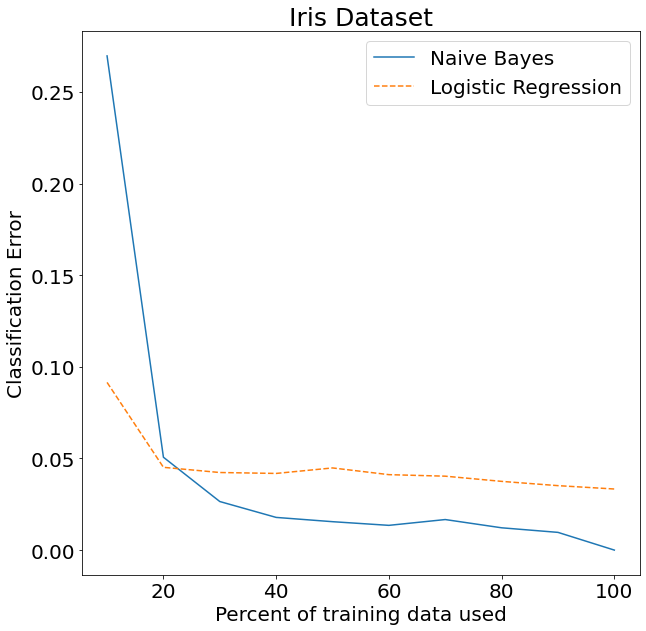

In [16]:
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

# 1. prepare the data for the two classifiers

# 2. compare the two classifiers on the dataset and generate the plots 
nbc = NBC(feature_types=['r', 'r', 'r', 'r'])
lr = LogisticRegression(max_iter=10000)
nbc_perf, lr_perf = compareNBCvsLR(nbc, lr, X, y)
makePlot(nbc_perf, lr_perf, title="Iris Dataset")

###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. To see it clearer, you should use only 100 data points from the dataset for this experiment.

In [17]:
# load the dataset
# TODO: insert your code for experiments
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################


voting = pd.read_csv('./voting.csv')

voting.info()

# 1. prepare the data for the two classifiers

# 1.1 handle missing data

# I would like to keep only those rows where at least 17-3=15 columns have finite values.
voting.dropna(thresh=(len(voting.columns)-3), inplace=True)

# drop irrelevant columns
voting.drop("water-project-cost-sharing", axis=1, inplace=True)
voting.drop("export-administration-act-south-africa", axis=1, inplace=True)

# fill remaining cells with most probable value
for column in voting:
  # print("---")
  missing_values = voting[column].isna()
  missing_values_sum = missing_values.sum()

  # print(missing_values_sum)

  if missing_values_sum != 0:
    props = voting[column].value_counts(normalize=True)
    # print("before props: " + str(props))
    pred_values = np.random.choice(props.index, p=props.values, size=missing_values_sum)
    voting.loc[missing_values, column] = pred_values
    # print("after props: " + str(voting[column].value_counts(normalize=True)))

  
voting.info()


# 1.2 handle text/categorial data
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
test = ordinal_encoder.fit_transform(voting)
np.unique(test, return_counts=True)

#voting.info()


# 1.3 shuffle data and pick 100 data points randomly
np.random.shuffle(test)
np.random.shuffle(test)

test = test[:100]

# 2. compare the two classifiers on the dataset and generate the plots 
X = test[:,1:]
y = test[:,0]
print(X.shape)
print(y.shape)
nbc = NBC(feature_types=['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'])
lr = LogisticRegression(max_iter=10000)
nbc_perf, lr_perf = compareNBCvsLR(nbc, lr, X, y)
makePlot(nbc_perf, lr_perf, title="Voting Dataset")



###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   label                                   435 non-null    object
 1   handicapped-infants                     423 non-null    object
 2   water-project-cost-sharing              387 non-null    object
 3   adoption-of-the-budget-resolution       424 non-null    object
 4   physician-fee-freeze                    424 non-null    object
 5   el-salvador-aid                         420 non-null    object
 6   religious-groups-in-schools             424 non-null    object
 7   anti-satellite-test-ban                 421 non-null    object
 8   aid-to-nicaraguan-contras               420 non-null    object
 9   mx-missile                              413 non-null    object
 10  immigration                             428 non-null    object
 11  synfue

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0